In [1]:
import numpy as np
import ast
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
import networkx as nx
import plotly.express as px

from scipy.special import logsumexp

%matplotlib inline
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")

In [2]:
# create a function to deal with non-homogeous dtype of columns. mixture of strings and lists
def string_to_list(s):
    try:
        return np.array(ast.literal_eval(s))  # Safely convert string to array
    except (ValueError, SyntaxError):
        return np.array(s)  # Return as array if object is not a list and conversion fails (e.g., NaN values)

In [3]:
BAD_RXNS = [
    "RXN-12440",
    "TRANS-RXN-121",
    "TRANS-RXN-300",
    "TRANS-RXN-8",
    "R15-RXN-MET/CPD-479//CPD-479/MET.25.",
    "TRANS-RXN-218",
    "TRANS-RXN0-601-PROTON//PROTON.15. (reverse)",
    "DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71."
    "DEPHOSICITDEHASE-RXN",
    "PHOSICITDEHASE-RXN",
    "GLYCOLALD-DEHYDROG-RXN",
    "ARCBTRANS-RXN",
    "RXN0-7332",
    "RXN0-7336",
    "2.7.1.121-RXN",
    "TRANS-RXN0-574-GLC//Glucopyranose.19.",
    "6PFRUCTPHOS-RXN__6PFK-2-CPX",
    "RXN0-313",
    "RXN0-7169",
    "RXN0-1483[CCO-PERI-BAC]-FE+2/PROTON/OXYGEN-MOLECULE//FE+3/WATER.54.",
    "RXN-22461",
    "RXN-22462",
    "RXN-22463",
    "PYRROLINECARBDEHYDROG-RXN",
    "RXN0-7008-PRO/UBIQUINONE-8//L-DELTA1-PYRROLINE_5-CARBOXYLATE/CPD-9956/PROTON.67.",
    "GLUCOKIN-RXN-GLC/ATP//ALPHA-GLC-6-P/ADP/PROTON.34.", # gets confused with PTS
    "PRPPSYN-RXN-CPD-15318/ATP//PRPP/AMP/PROTON.31.", # duplicate
    "TRANS-RXN0-574-GLC//GLC.9.", # duplicate
    "GLUCOKIN-RXN-GLC/ATP//D-glucopyranose-6-phosphate/ADP/PROTON.48.", # duplicate
]

# not key central carbon met
BAD_RXNS.extend(
    [
        "RXN-6161",
        "R15-RXN-MET/PYRUVATE//CPD-479/L-ALPHA-ALANINE.38.",
        "R15-RXN-MET/GLYOX//CPD-479/GLY.23. (reverse)",
    ]
)

# isomers, that might be used but not in conditions tested
BAD_RXNS.extend(
    [
        "ASPAMINOTRANS-RXN__TYRB-DIMER",
        "325-BISPHOSPHATE-NUCLEOTIDASE-RXN",
        "ACETOLACTSYN-RXN",
        "ASNSYNA-RXN__ASNSYNB-CPLX",
        "ASPARTATEKIN-RXN__ASPKINIHOMOSERDEHYDROGI-CPLX",
        "DAHPSYN-RXN__AROH-CPLX",
        "F16ALDOLASE-RXN__FRUCBISALD-CLASSI",
        "RXN-9535__FABB-CPLX",
        "MALATE-DEH-RXN (reverse)",
    ]
)

# alt electron transfer
BAD_RXNS.extend(["1.5.1.20-RXN-CPD-1302/NADP//CPD-12996/NADPH/PROTON.38."])

# weird atp cycling
BAD_RXNS.extend(
    [
        "BARA-RXN",
        "RXN0-6561",
        "RXN0-7337",
        "CHEBDEP-RXN",
        "RXN0-6542",
        "RXN0-6547",
        "NRIIPHOS-RXN",
        "RXN0-7372",
        "RXN0-7380",
        "RXN0-7378",
        "URIDYLREM-RXN",
        "URITRANS-RXN",
        "RXN-16381",
    ]
)

FREE_RXNS = [
    "TRANS-RXN-145",
    "TRANS-RXN0-545",
    "TRANS-RXN0-474",
    "ATPSYN-RXN (reverse)",
]

## Load Experiments

In [4]:
# load new simulation output
time = '400'
date = '2025-01-30'
experiment = 'NEW_updated_bad_rxn'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_new = output['listeners']['fba_results']
bulk = pd.DataFrame(output['bulk'])

In [5]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [6]:
# get commonly stored variables
metabolism = agent['ecoli-metabolism-redux-classic']
stoichiometry = metabolism.stoichiometry
reaction_names = metabolism.reaction_names
kinetic_reaction_ids = metabolism.kinetic_constraint_reactions
fba_new_reaction_ids = metabolism.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = metabolism.parameters['fba_reaction_ids_to_base_reaction_ids']
binary_kinetic_idx = metabolism.binary_kinetic_idx
metabolites = metabolism.metabolite_names

## Understand Stoichiometry Matrix

In [7]:
print('Stoichiometry Matrix Shape:', stoichiometry.shape)
print('There are {} reactions and {} metabolites'.format(stoichiometry.shape[1], stoichiometry.shape[0]))

Stoichiometry Matrix Shape: (6076, 9358)
There are 9358 reactions and 6076 metabolites


In [8]:
metabolite_idx_to_name = {i:metabolite for i, metabolite in enumerate(metabolites)}
S = pd.DataFrame(stoichiometry, columns=reaction_names, index=metabolites)

# parse through the stoichiometry matrix to get no production or consumption metabolites
dead_end_metabolites_no_use = []
dead_end_metabolites_no_prod = []
for met in metabolites:
    if not np.any(S.loc[met] < 0): # if the metabolite doesn't have an outlet/consumption
        dead_end_metabolites_no_use.append(met)
    if not np.any(S.loc[met] > 0): # if the metabolite doesn't have an inlet/production
        dead_end_metabolites_no_prod.append(met)

print('The number of dead-end metabolites with no consumption: {}'.format(len(dead_end_metabolites_no_use)))  
print('The number of dead-end metabolites with no production: {}'.format(len(dead_end_metabolites_no_prod)))  
print('Overlap between the two lists are:{}'.format(list(set(dead_end_metabolites_no_use) & set(dead_end_metabolites_no_prod))))

The number of dead-end metabolites with no consumption: 634
The number of dead-end metabolites with no production: 696
Overlap between the two lists are:[]


In [9]:
dead_end_metabolites_no_use

['1-2-Diglycerides[c]',
 '1-Lyso-phospholipids[p]',
 '1-Lysophosphatidylglycerols[p]',
 '1-Lysophosphatidylserines[p]',
 '16S-rRNA-2-O-methylcytidine1402[c]',
 '16S-rRNA-5-O-methylcytosine1407[c]',
 '16S-rRNA-5-O-methylcytosine967[c]',
 '16S-rRNA-N2-methylguanine1207[c]',
 '16S-rRNA-N2-methylguanine966[c]',
 '16S-rRNA-N2methylguanine1516[c]',
 '16S-rRNA-N3-methyluracil1498[c]',
 '16S-rRNA-N4-methylcytidine1402[c]',
 '16S-rRNA-N6-dimethyladenine1518-1519[c]',
 '16S-rRNA-N7-methylguanine527[c]',
 '16S-rRNA-pseudouridine516[c]',
 '2-Acyl-sn-glycerol-3-phosphates[p]',
 '2-Acylglycero-Phosphocholines[c]',
 '2-CARBOXYMUCONATE[p]',
 '2-DEOXY-D-GLUCOSE[c]',
 '2-HYDROXYGLUTARIC_ACID[c]',
 '2-O-Methylcytidine-32-tRNAs[c]',
 '2-O-Methylcytidine-34-tRNAs[c]',
 '2-O-Methylguanosine18[c]',
 '2-O-Methyluridine32-tRNA[c]',
 '2-PROTOCATECHUOYLPHLOROGLUCINOLCARBOXYLA[c]',
 '2-Prime-Phosphate-Terminated-RNAs[c]',
 '2-THIOURIDINE[c]',
 '2-Thiocytosine-32-In-tRNAs[c]',
 '23S-RRNA-N2-METHYLGUANINE2445[c]',


In [10]:
dead_end_metabolites_no_prod

['1-Palmitoyl-2-Acyl-Glycerol-P[p]',
 '11-DEOXYCORTICOSTERONE[c]',
 '16S-rRNA-adenine1518-adenine1519[c]',
 '16S-rRNA-cytidine1402[c]',
 '16S-rRNA-cytosine1407[c]',
 '16S-rRNA-cytosine967[c]',
 '16S-rRNA-guanine-1207[c]',
 '16S-rRNA-guanine-527[c]',
 '16S-rRNA-guanine-966[c]',
 '16S-rRNA-guanine1516[c]',
 '16S-rRNA-uracil1498[c]',
 '16S-rRNA-uridine516[c]',
 '1iNisup6sup-ethenoadenine-in-DNA[c]',
 '2-DEHYDRO-3-DEOXY-D-GLUCONATE[p]',
 '2-Lysophosphatidylcholines[p]',
 '2-O-ALPHA-MANNOSYL-D-GLYCERATE[p]',
 '2-OXOBUTANOATE[p]',
 '2-PG[p]',
 '23-Diaminopropanoate[c]',
 '23S-rRNA-adenine-1618[c]',
 '23S-rRNA-adenine-2030[c]',
 '23S-rRNA-adenine-2503[c]',
 '23S-rRNA-cytidine-2498[c]',
 '23S-rRNA-cytosine-1962[c]',
 '23S-rRNA-cytosine-2501[c]',
 '23S-rRNA-guanine-1835[c]',
 '23S-rRNA-guanine-2069[c]',
 '23S-rRNA-guanine-2445[c]',
 '23S-rRNA-guanine-2551[c]',
 '23S-rRNA-guanine-745[c]',
 '23S-rRNA-pseudouridine1915[c]',
 '23S-rRNA-uracil-1939[c]',
 '23S-rRNA-uracil-747[c]',
 '23S-rRNA-uridine-

In [11]:
# get dead-end metabolites related to new reactions
S_new_rxn = S.loc[:, fba_new_reaction_ids] # slice S with new reactions -> all metabolites x new reactions
S_new_met = S.loc[~np.all(S_new_rxn == 0, axis=1), :] # slice S with new metabolites involved in new reactions -> met in new reactions x all reactions
S_new = S_new_met.loc[:,~np.all(S_new_met == 0, axis=0)] # slice S_new_met with reactions involving met in new reactions -> met in new reactions x reactions using those mets (more than new rxns)

# get dead-end metabolites related to S_dem_new
# parse through the stoichiometry matrix to get no production or consumption metabolites
dem_no_use_new = []
dem_no_prod_new = []
for met in S_new.index:
    if not np.any(S_new.loc[met] < 0): # if the metabolite doesn't have an outlet/consumption
        dem_no_use_new.append(met)
    if not np.any(S_new.loc[met] > 0): # if the metabolite doesn't have an inlet/production
        dem_no_prod_new.append(met)

print('The number of dead-end metabolites associated with new reactions with no consumption: {}'.format(len(dem_no_use_new)))  
print('The number of dead-end metabolites associated with new reactions with no production: {}'.format(len(dem_no_prod_new))) 
print('Overlap between the two lists are:{}'.format(list(set(dem_no_use_new) & set(dem_no_prod_new))))
print('Dimension of S_new is: {}'.format(S_new.shape))

The number of dead-end metabolites associated with new reactions with no consumption: 83
The number of dead-end metabolites associated with new reactions with no production: 88
Overlap between the two lists are:[]
Dimension of S_new is: (730, 4761)


S_new_dem shape is: (171, 254)


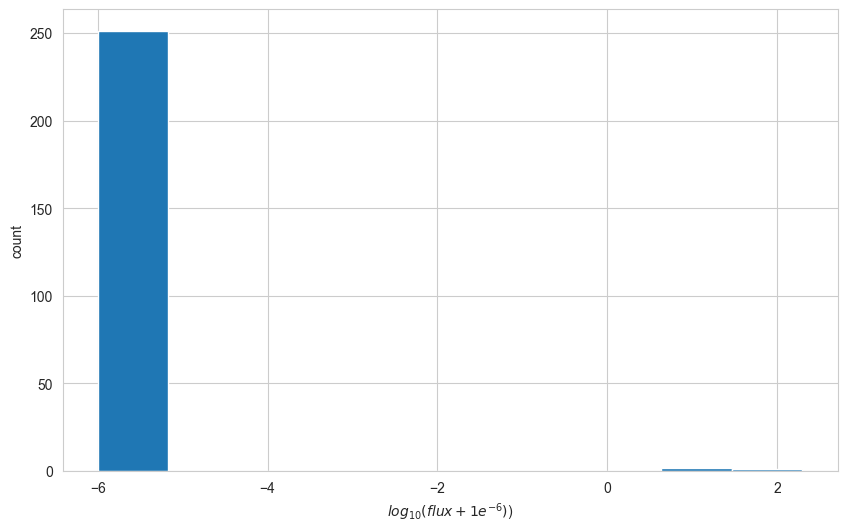

In [12]:
%matplotlib inline
# plot the flux of these reactions - should be all zero if they are really treated as dead-end
# create flux dataframe
sim = pd.DataFrame(fba_new["estimated_fluxes"], columns= reaction_names).mean(axis=0)
target_fluxes = pd.DataFrame(fba_new["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :]
sim += 1e-6
sim = np.log10(sim)
df_all = pd.DataFrame({'new_sim_fluxes': sim, 'is_new': ['New Reactions' if id in fba_new_reaction_ids else 'Old Reactions' for id in reaction_names]})

dem_new = np.concatenate([dem_no_prod_new, dem_no_use_new])
temp = S_new.loc[dem_new, :] # slice S_dem_new with new dead-end mets
S_new_dem = S_new.loc[dem_new, ~np.all(temp == 0, axis=0)]# only consider the reactions involving the dead-end mets
print('S_new_dem shape is: {}'.format(S_new_dem.shape))

# plot
plt.figure(figsize=(10, 6))
plt.hist(df_all.loc[S_new_dem.columns, 'new_sim_fluxes'])
plt.xlabel(r"$log_{10}(flux+1e^{-6})$)")
plt.ylabel(r"count")
plt.show()

In [13]:
# find such reactions with non-zero flux
df_met_new = df_all.loc[S_new_met.columns, :]
non_zero_flux_rxn = df_met_new[df_met_new.new_sim_fluxes != -6]
non_zero_flux_rxn

,new_sim_fluxes,is_new
1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse),3.250625,Old Reactions
1.5.1.20-RXN-5-METHYL-THF/NADP//METHYLENE-THF/NADPH/PROTON.46. (reverse),0.270097,Old Reactions
1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36. (reverse),3.670325,Old Reactions
1.5.1.20-RXN-CPD-1302/NADP//CPD-12996/NADPH/PROTON.38. (reverse),1.984887,Old Reactions
1.8.4.8-RXN (reverse),3.885464,Old Reactions
...,...,...
UROGENDECARBOX-RXN,1.195692,Old Reactions
UROGENIIISYN-RXN,1.496688,Old Reactions
XANPRIBOSYLTRAN-RXN (reverse),-0.869663,Old Reactions
glycogen-monomer-extension,4.007446,Old Reactions


<p> The dead-end metabolites in those three rxns are: REDUCED-MENAQUINONE[c], CPD-9956[c], and CL-[c] </p>

In [14]:
print('The new dead-end metabolites in those three rxns are: REDUCED-MENAQUINONE[c], "CPD-9956[c], and CL-[c]')

The new dead-end metabolites in those three rxns are: REDUCED-MENAQUINONE[c], "CPD-9956[c], and CL-[c]


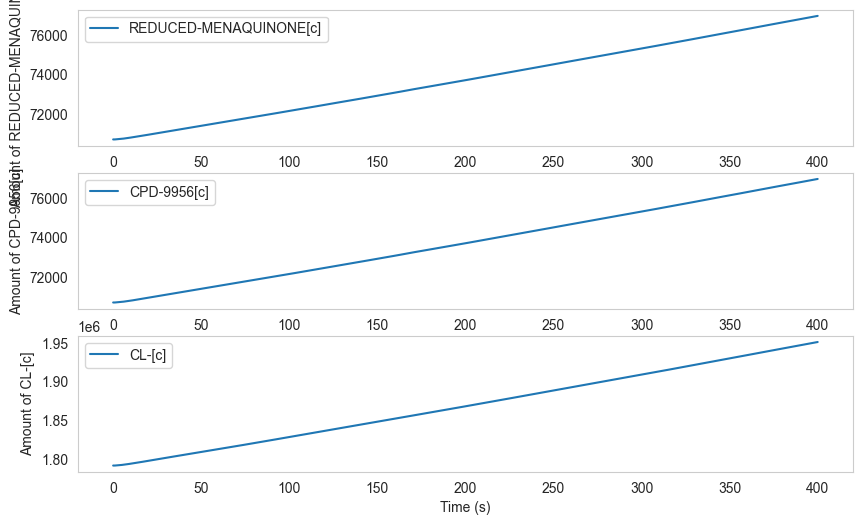

In [15]:
# Check the counts of these metabolites through time, if true root no consumption and
# hence a dead-end, then there should be accumulation of these mets
dem_of_interest = ['REDUCED-MENAQUINONE[c]', 'CPD-9956[c]', 'CL-[c]']
dem_of_interest_bulk_idx = bulk_name_to_idx(dem_of_interest, metabolism.bulk_ids)
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(bulk[dem_of_interest_bulk_idx[0]], label="REDUCED-MENAQUINONE[c]")
plt.xlabel('Time (s)')
plt.ylabel("Amount of REDUCED-MENAQUINONE[c]")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(bulk[dem_of_interest_bulk_idx[1]], label="CPD-9956[c]")
plt.xlabel('Time (s)')
plt.ylabel("Amount of CPD-9956[c]")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(bulk[dem_of_interest_bulk_idx[2]], label="CL-[c]")
plt.xlabel('Time (s)')
plt.ylabel("Amount of CL-[c]")
plt.legend()
plt.grid()
plt.show()

<p> Next, I want to try plotting the log(count) over time to see if there is fluctuation to those 15 metabolites; if yes, then those metabolites are not true dead-end and should be removed from the list </p>

In [16]:
idx = bulk_name_to_idx(dem_new, metabolism.bulk_ids)
table = counts(bulk.mean(axis=0), idx)
table.index = dem_new
table

2-DEHYDRO-3-DEOXY-D-GLUCONATE[p]        0.000000
23-Diaminopropanoate[c]                 0.000000
3-KETOBUTYRATE[p]                       0.000000
5-DEHYDROGLUCONATE[p]                   0.000000
ACYL-COA[c]                            29.738155
                                        ...     
PYRUVFORMLY-MONOMER[c]                  0.932668
Peptide-Holder-Alternative[c]           0.000000
REDUCED-MENAQUINONE[c]              73752.483791
Red-Hybrid-Cluster-Proteins[c]          0.000000
STEARIC_ACID[p]                         0.000000
Length: 171, dtype: float64

In [17]:
# plot non-zero counts of dead-end mets and check accumulation. If no consumption, should accumulate
non_zero_dem_idx = idx[table != 0]
# plt.figure(figsize=(10, 6))
# plt.plot(np.log(bulk[non_zero_dem_idx]))
df = pd.DataFrame(np.log(bulk[non_zero_dem_idx]+1e-1))
df.columns = dem_new[table!=0]
fig = px.line(df, x = df.index, y = df.columns)
fig.show(renderer = 'browser')

Text(0, 0.5, 'Flux')

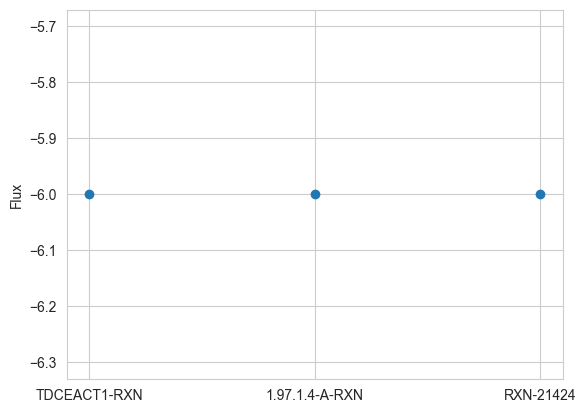

In [18]:
# plot fluxome of reactions involving the fluxuating metabolites: ETR-Quinols[c] and ETR-Semiquinones[c], KETOBUTFORMLY-MONOMER[c] and PYRUCFORMLY-MONOMER[c]
rxn_of_interest = ['TDCEACT1-RXN', '1.97.1.4-A-RXN', 'RXN-21424']
plt.plot(df_all.loc[rxn_of_interest, 'new_sim_fluxes'], 'o')
plt.ylabel('Flux')

In [19]:
dem_new[table!=0]

array(['ACYL-COA[c]', 'ADP-SUGARS[c]', 'APO-CITRATE-LYASE[c]',
       'CPLX0-7849[c]', 'ETR-Quinols[c]',
       'KETOBUTFORMLY-INACT-MONOMER[c]', 'PYRUVFORMLY-INACTIVE-CPLX[c]',
       'A-PEPTIDOGLYCAN-MDAP-TRIPEPTIDE[p]', 'CL-[c]', 'CPD-9956[c]',
       'ENTB-CPLX[c]', 'ETR-Semiquinones[c]', 'KETOBUTFORMLY-MONOMER[c]',
       'PYRUVFORMLY-MONOMER[c]', 'REDUCED-MENAQUINONE[c]'], dtype='<U38')

In [20]:
# clean up dem_new by removing false dead-end mets
dem_to_remove = ('ETR-Quinols[c]', 'ETR-Semiquinones[c]', 
                 'KETOBUTFORMLY-INACT-MONOMER[c]', 'KETOBUTFORMLY-MONOMER[c]',
                 'PYRUVFORMLY-INACTIVE-CPLX[c]', 'PYRUVFORMLY-MONOMER[c]')
temp = set(dem_new.copy())
dem_new_clean = temp.difference(dem_to_remove)

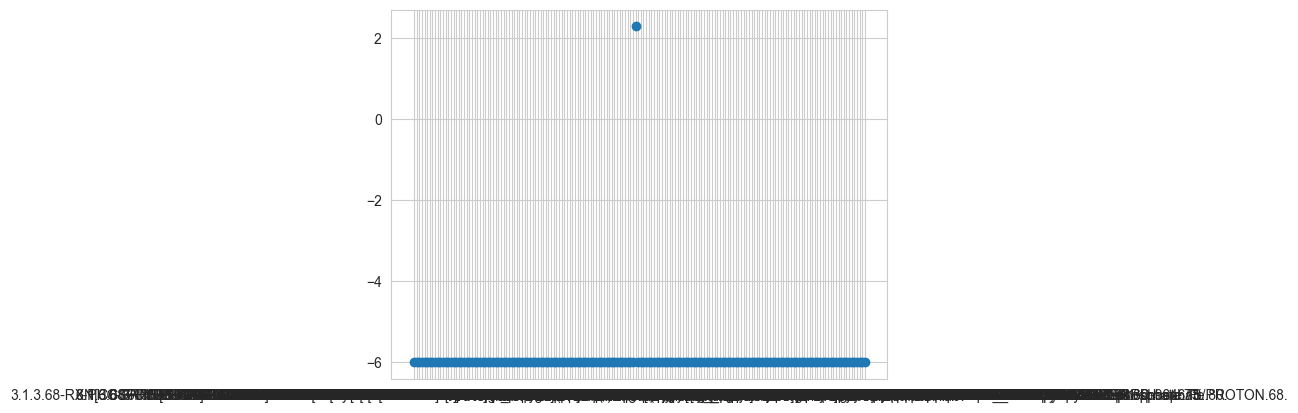

In [21]:
# plot new reaction fluxes of these dems
df_new = df_all[df_all.is_new == 'New Reactions']
S_of_interest = S.loc[list(dem_new_clean),:]
S_new_rxn_w_new_dem = S_of_interest.loc[:,~np.all(S_of_interest == 0, axis=0)] # important: this is the stoichiometry matrix of new reactions involving new dead-end mets
rxn_of_interest = S_new_rxn_w_new_dem.columns
temp = df_all.loc[rxn_of_interest]
df_new_dem = temp[temp.is_new == 'New Reactions'] 

plt.plot(df_new_dem.new_sim_fluxes, 'o')

In [22]:
df_new_dem

,new_sim_fluxes,is_new
1.11.1.15-RXN,-6.0,New Reactions
2.7.7.61-RXN,-6.0,New Reactions
2.9.1.1-RXN,-6.0,New Reactions
3.1.3.68-RXN[CCO-CYTOSOL]-2-DEOXY-D-GLUCOSE-6-PHOSPHATE/WATER//2-DEOXY-D-GLUCOSE/Pi.71.,-6.0,New Reactions
3.1.3.68-RXN[CCO-CYTOSOL]-2-DEOXY-D-GLUCOSE-6-PHOSPHATE/WATER//2-DEOXY-D-GLUCOSE/Pi.71.__G6932-MONOMER,-6.0,New Reactions
...,...,...
TRANS-RXN0-618-PTSI-PHOSPHORYLATED/CPD-10725//PTSI-MONOMER/D-fructopyranose-1-phosphate.73.,-6.0,New Reactions
TRANS-RXN0-618-PTSI-PHOSPHORYLATED/CPD-10726//PTSI-MONOMER/D-fructopyranose-1-phosphate.73.,-6.0,New Reactions
TRANS-RXN0-618-PTSI-PHOSPHORYLATED/D-Fructopyranose//PTSI-MONOMER/D-fructopyranose-1-phosphate.80.,-6.0,New Reactions
TRANS-RXN0-629,-6.0,New Reactions


## Focus on Acceptor[i] aka. Acceptor[CCO-PM-BAC-NEG] in RXN-21407 (new reaction with zero flux) -> this will probably be solution II, need much longer time to do

In [23]:
for index in df_new_dem.index:
    temp = S_new_rxn_w_new_dem.loc[:,index]
    rxn_dem = temp[temp != 0].index.to_numpy()
    df_new_dem.loc[index, 'dem_involved'] = str(rxn_dem)
df_new_dem

,new_sim_fluxes,is_new,dem_involved
1.11.1.15-RXN,-6.0,New Reactions,['Alcohols[c]' 'Alkyl-Hydro-Peroxides[c]']
2.7.7.61-RXN,-6.0,New Reactions,['APO-CITRATE-LYASE[c]']
2.9.1.1-RXN,-6.0,New Reactions,['L-seryl-SEC-tRNAs[c]' 'Charged-SEC-tRNAs[c]']
3.1.3.68-RXN[CCO-CYTOSOL]-2-DEOXY-D-GLUCOSE-6-PHOSPHATE/WATER//2-DEOXY-D-GLUCOSE/Pi.71.,-6.0,New Reactions,['2-DEOXY-D-GLUCOSE[c]']
3.1.3.68-RXN[CCO-CYTOSOL]-2-DEOXY-D-GLUCOSE-6-PHOSPHATE/WATER//2-DEOXY-D-GLUCOSE/Pi.71.__G6932-MONOMER,-6.0,New Reactions,['2-DEOXY-D-GLUCOSE[c]']
...,...,...,...
TRANS-RXN0-618-PTSI-PHOSPHORYLATED/CPD-10725//PTSI-MONOMER/D-fructopyranose-1-phosphate.73.,-6.0,New Reactions,['D-fructopyranose-1-phosphate[c]']
TRANS-RXN0-618-PTSI-PHOSPHORYLATED/CPD-10726//PTSI-MONOMER/D-fructopyranose-1-phosphate.73.,-6.0,New Reactions,['D-fructopyranose-1-phosphate[c]']
TRANS-RXN0-618-PTSI-PHOSPHORYLATED/D-Fructopyranose//PTSI-MONOMER/D-fructopyranose-1-phosphate.80.,-6.0,New Reactions,['D-Fructopyranose[p]' 'D-fructopyranose-1-pho...
TRANS-RXN0-629,-6.0,New Reactions,['PQQ[p]' 'PQQ[e]']


## change environmental condition - add nitrate in the environment and see if the flux of RXN0-2721 changes

array([11271, 11264, 11267, 11259, 11260, 11261])

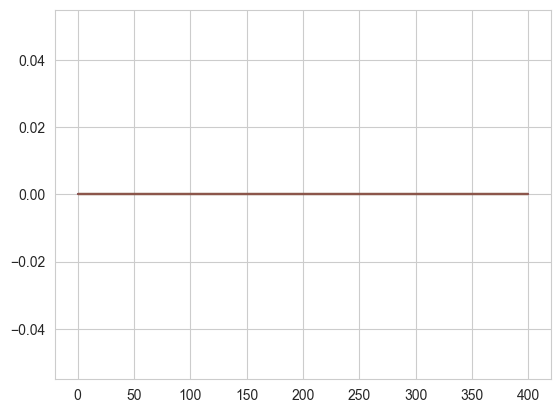

In [24]:
idx = bulk_name_to_idx(['NITROUS-OXIDE[c]', 'NITRIC-OXIDE[c]', 'NITRITE[c]', 'NITRATE[c]', 'NITRATE[p]', 'NITRATE[e]'], metabolism.bulk_ids)
plt.plot(bulk[idx])
idx

<p> currently, there is no external nitrate in the environment </p>

#### Add nitrate to the environment

In [25]:
uptake = metabolism.allowed_exchange_uptake
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set([
        # "NITRATE[e]",
        # "NITRATE[p]",
        # "FRU[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
])
removals = set([
                  # "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
])


uptake = uptake | addition
uptake = uptake - removals

In [26]:
model = NetworkFlowModel(
            stoich_arr=stoichiometry,
            metabolites=metabolism.metabolite_names,
            reactions=metabolism.reaction_names,
            homeostatic_metabolites=metabolism.homeostatic_metabolites,
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)

In [27]:
model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=uptake)

In [56]:
homeostatic_count = pd.DataFrame(fba_new["homeostatic_metabolite_counts"], columns=metabolism.homeostatic_metabolites).loc[24, :]
homeostatic = pd.DataFrame(fba_new["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :]
maintenance = pd.DataFrame(fba_new["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]
kinetic = pd.DataFrame(fba_new["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :]

objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.0000001}
solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_count * metabolism.counts_to_molar.asNumber(), # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic).values())), # *10^7
            maintenance_target=maintenance, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            binary_kinetic_idx=binary_kinetic_idx,
            force_flow_idx=None,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.GLOP)

In [29]:
solution_add_nitrate = solution.velocities
reaction_names = metabolism.reaction_names
# pd.Series(solution.exchanges, index=metabolism.exchange_molecules)
sim_flux_nitrate = pd.DataFrame({'flux': solution_add_nitrate, 'is_new': ['New Reactions' if id in fba_new_reaction_ids else 'Old Reactions' for id in reaction_names]}, index = reaction_names)

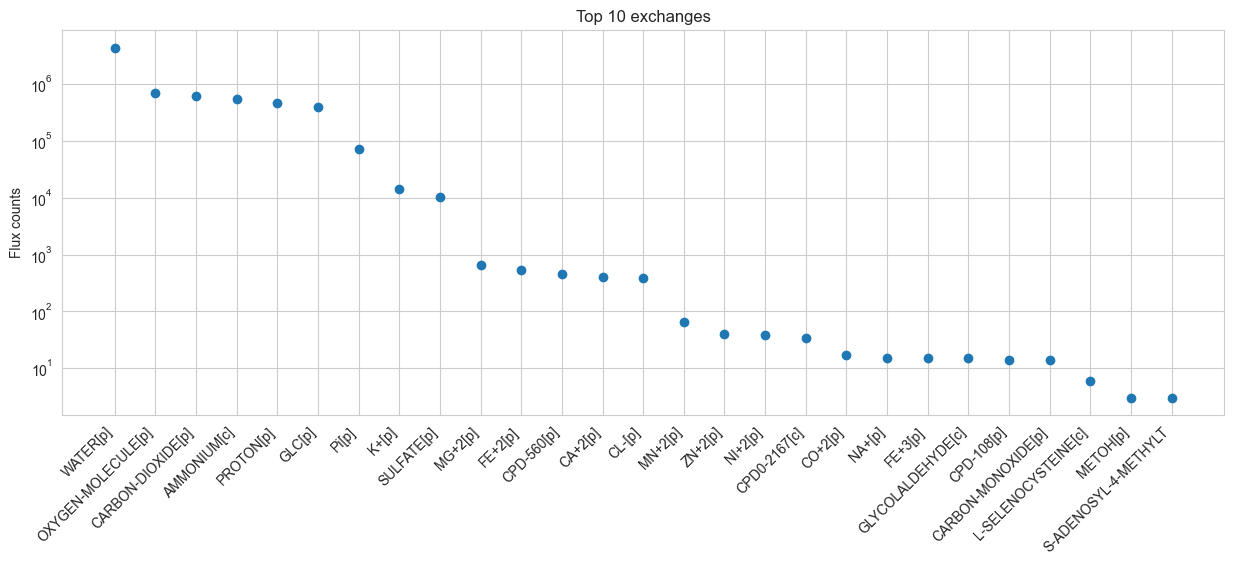

In [30]:
cur_exchanges = pd.Series(solution.exchanges, index=metabolism.metabolite_names).abs().sort_values(ascending=False)
nonzero = len(cur_exchanges[cur_exchanges > 0])

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(cur_exchanges.head(nonzero), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 exchanges')
plt.show()

In [57]:
# get all ['NITROUS-OXIDE[c]', 'NITRIC-OXIDE[c]', 'NITRITE[c]', 'NITRATE[c]', 'NITRATE[p]', 'NITRATE[e]'] related reactions
met_of_interest = ['NITROUS-OXIDE[c]','NITROUS-OXIDE[p]','NITROUS-OXIDE[e]', 'NITRIC-OXIDE[c]', 'NITRITE[c]', 'NITRATE[c]', 'NITRATE[p]', 'NITRATE[e]']
S_met = S.loc[met_of_interest, :]
S_met = S_met.loc[:,~np.all(S_met == 0, axis=0)]
rxn_nitrate = S_met.columns
%store rxn_nitrate

Stored 'rxn_nitrate' (Index)


In [32]:
nitrate_flux_original = sim_flux_nitrate.loc[rxn_nitrate]
nitrate_flux_original

,flux,is_new
NITRATE-REDUCTASE-CYTOCHROME-RXN-Reduced-NapC-proteins/NITRATE/PROTON//Oxidized-NapC-proteins/NITRITE/WATER.75.,-0.0,Old Reactions
R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.,-0.0,New Reactions
R621-RXN-NITRIC-OXIDE/NADPH/OXYGEN-MOLECULE//NITRATE/NADP/PROTON.56.,-0.0,New Reactions
RXN-13854 (reverse),-0.0,Old Reactions
RXN-23276,-0.0,Old Reactions
RXN-23850 (reverse),0.0,Old Reactions
RXN0-2721,0.0,New Reactions
RXN0-3501-NITRATE/REDUCED-MENAQUINONE/PROTON//NITRITE/CPD-9728/WATER/PROTON.66.,-0.0,New Reactions
RXN0-6369-NITRATE/CPD-9956//NITRITE/UBIQUINONE-8/WATER.45.,-0.0,Old Reactions
RXN0-7124-NITRATE/CPD-9956/PROTON//NITRITE/UBIQUINONE-8/PROTON/WATER.59.,-0.0,New Reactions


In [33]:
S_met

,NITRATE-REDUCTASE-CYTOCHROME-RXN-Reduced-NapC-proteins/NITRATE/PROTON//Oxidized-NapC-proteins/NITRITE/WATER.75.,R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.,R621-RXN-NITRIC-OXIDE/NADPH/OXYGEN-MOLECULE//NITRATE/NADP/PROTON.56.,RXN-13854 (reverse),RXN-23276,RXN-23850 (reverse),RXN0-2721,RXN0-3501-NITRATE/REDUCED-MENAQUINONE/PROTON//NITRITE/CPD-9728/WATER/PROTON.66.,RXN0-6369-NITRATE/CPD-9956//NITRITE/UBIQUINONE-8/WATER.45.,RXN0-7124-NITRATE/CPD-9956/PROTON//NITRITE/UBIQUINONE-8/PROTON/WATER.59.,TRANS-RXN-137,TRANS-RXN-137 (reverse),TRANS-RXN0-239,TRANS-RXN0-600-NITROUS-OXIDE//NITROUS-OXIDE.29.,TRANS-RXN0-600-NITROUS-OXIDE//NITROUS-OXIDE.29. (reverse),TRANS-RXN0-601-NITRATE//NITRATE.17.,TRANS-RXN0-601-NITRATE//NITRATE.17. (reverse)
NITROUS-OXIDE[c],0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
NITROUS-OXIDE[p],0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0
NITROUS-OXIDE[e],0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0
NITRIC-OXIDE[c],0,-2,-2,0,-1,1,-2,0,0,0,0,0,0,0,0,0,0
NITRITE[c],0,0,0,-1,0,-1,0,1,0,1,1,-1,-1,0,0,0,0
NITRATE[c],0,2,2,0,0,0,0,-1,0,-1,0,0,1,0,0,0,0
NITRATE[p],-1,0,0,0,0,0,0,0,-1,0,0,0,-1,0,0,-1,1
NITRATE[e],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1


It becomes clear, by investigating the fluxome of small subset of Nitrate related reactions and the corresponding stoichiometry to realize, that Nitrate[e] is imported from the extracellular space by TRANS-RXN0-601 (reverse), then transported into cytoplasmic space by TRANS-RXN0-239. Then Nitrate[c] makes Nitrite[c] through RXN0-3501, but then Nitrite[c] enters TRANS-RXN0-239 again to get transported to perisplasmic space. The loop continues.  

The good new, though, is that by allowing environmental exchange of Nitrate, the flux of TRANS-RXN0-601 (reverse), TRANS-RXN0-239, and RXN0-3501, which was zero before, is now non-zero.

Further Explore:
1. Allow NITROUS-OXIDE exchange. See if the flux of RXN-21407 changes
2. Allow NITRATE exchange, but also force flow through RXN-223850 (reverse) - to force production of NITRIC-OXIDE[c]. 

In [34]:
rxn_nitrate[np.isin(rxn_nitrate, kinetic_reaction_ids)]
target_fluxes.loc[rxn_nitrate[np.isin(rxn_nitrate, kinetic_reaction_ids)]]

R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.    145988.0
Name: 24, dtype: float64

### What if we simply allow NITROUS-OXIDE exchange. See if the flux of RXN-21407 changes

In [35]:
uptake = metabolism.allowed_exchange_uptake
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set([
    "NITROUS-OXIDE[e]",
    # "NITRATE[e]",
])
removals = set([
])


uptake = uptake | addition
uptake = uptake - removals

In [36]:
#TODO: Add transport of and reduction of NITROUS-OXIDE[p] to [c] and in [c]
print(stoichiometry.shape)
new_reaction_names = metabolism.reaction_names.copy()
new_reaction_names.append('TEMP-TRANS-NITROUS-OXIDE[p]-[c]')
new_reaction_names.append('TEMP-TRANS-NITROUS-OXIDE[p]-[c] (reverse)')
new_reaction_names.append('TEMP-NITROUS-OXIDE[c]-REDUCT')

new_reaction = np.zeros((stoichiometry.shape[0], 3))
new_reaction[metabolites.index('NITROUS-OXIDE[p]'), 0] = -1
new_reaction[metabolites.index('NITROUS-OXIDE[c]'), 0] = 1
new_reaction[metabolites.index('NITROUS-OXIDE[p]'), 1] = 1
new_reaction[metabolites.index('NITROUS-OXIDE[c]'), 1] = -1
new_reaction[metabolites.index('NITROUS-OXIDE[c]'), 2] = -2
new_reaction[metabolites.index('OXYGEN-MOLECULE[c]'), 2] = -1
new_reaction[metabolites.index('NITRIC-OXIDE[c]'), 2] = 4

new_stoichiometry = np.concatenate((stoichiometry, new_reaction), axis=1)
new_stoichiometry.shape

(6076, 9358)


(6076, 9361)

In [37]:
model = NetworkFlowModel(
            stoich_arr=new_stoichiometry,
            metabolites=metabolism.metabolite_names,
            reactions=reaction_names,
            homeostatic_metabolites=metabolism.homeostatic_metabolites,
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)

In [38]:
model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=uptake)

In [39]:
solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_count * metabolism.counts_to_molar.asNumber(), # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic).values())), # *10^7
            maintenance_target=maintenance, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            binary_kinetic_idx=binary_kinetic_idx,
            force_flow_idx=None,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.GLOP)

In [40]:
len(reaction_names)

9358

In [54]:
solution_add_nitrous = solution.velocities
%store solution_add_nitrous
# pd.Series(solution.exchanges, index=metabolism.exchange_molecules)
# solution_add_nitrous+= 1e-6
# solution_add_nitrous = np.log10(solution_add_nitrous)
sim_flux_nitrous = pd.DataFrame({'flux': solution_add_nitrous, 'is_new': ['New Reactions' if id in fba_new_reaction_ids else 'Old Reactions' for id in new_reaction_names]}, index = new_reaction_names)

Stored 'solution_add_nitrous' (ndarray)


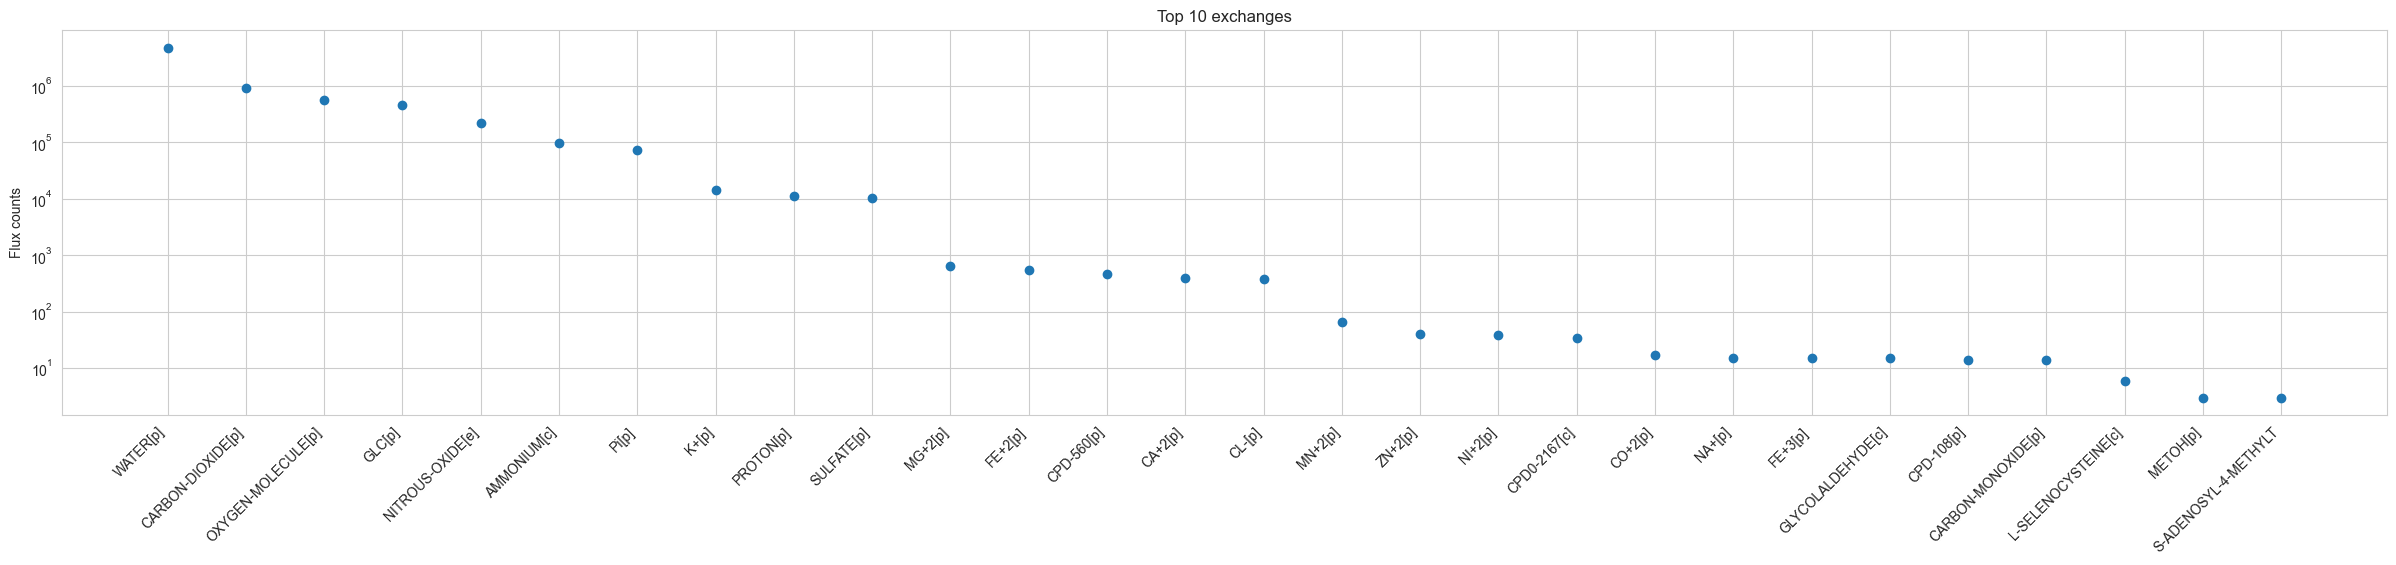

In [42]:
cur_exchanges = pd.Series(solution.exchanges, index=metabolism.metabolite_names).abs().sort_values(ascending=False)
nonzero = len(cur_exchanges[cur_exchanges > 0])

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(30, 5))
plt.plot(cur_exchanges.head(nonzero), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 exchanges')
plt.show()

In [43]:
met_of_interest = ['NITROUS-OXIDE[c]','NITROUS-OXIDE[p]','NITROUS-OXIDE[e]', 'NITRIC-OXIDE[c]', 'NITRITE[c]', 'NITRATE[c]', 'NITRATE[p]', 'NITRATE[e]']
# met_of_interest = ['NITROUS-OXIDE[c]','NITROUS-OXIDE[p]','NITROUS-OXIDE[e]', 'NITRIC-OXIDE[c]']

S_temp = pd.DataFrame(new_stoichiometry, columns=new_reaction_names, index=metabolites)
S_met_temp = S_temp.loc[met_of_interest, :]
S_met_temp = S_met_temp.loc[:,~np.all(S_met_temp == 0, axis=0)]
rxn_nitrous_temp = S_met_temp.columns

In [44]:
nitrate_flux_after = sim_flux_nitrous.loc[rxn_nitrous_temp]
nitrate_flux_after

,flux,is_new
NITRATE-REDUCTASE-CYTOCHROME-RXN-Reduced-NapC-proteins/NITRATE/PROTON//Oxidized-NapC-proteins/NITRITE/WATER.75.,-0.000000,Old Reactions
R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.,145988.000000,New Reactions
R621-RXN-NITRIC-OXIDE/NADPH/OXYGEN-MOLECULE//NITRATE/NADP/PROTON.56.,77164.141975,New Reactions
RXN-13854 (reverse),-0.000000,Old Reactions
RXN-23276,-0.000000,Old Reactions
RXN-23850 (reverse),-0.000000,Old Reactions
RXN0-2721,-0.000000,New Reactions
RXN0-3501-NITRATE/REDUCED-MENAQUINONE/PROTON//NITRITE/CPD-9728/WATER/PROTON.66.,138838.737654,New Reactions
RXN0-6369-NITRATE/CPD-9956//NITRITE/UBIQUINONE-8/WATER.45.,-0.000000,Old Reactions
RXN0-7124-NITRATE/CPD-9956/PROTON//NITRITE/UBIQUINONE-8/PROTON/WATER.59.,307465.546296,New Reactions


In [45]:
S_met_temp

,NITRATE-REDUCTASE-CYTOCHROME-RXN-Reduced-NapC-proteins/NITRATE/PROTON//Oxidized-NapC-proteins/NITRITE/WATER.75.,R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.,R621-RXN-NITRIC-OXIDE/NADPH/OXYGEN-MOLECULE//NITRATE/NADP/PROTON.56.,RXN-13854 (reverse),RXN-23276,RXN-23850 (reverse),RXN0-2721,RXN0-3501-NITRATE/REDUCED-MENAQUINONE/PROTON//NITRITE/CPD-9728/WATER/PROTON.66.,RXN0-6369-NITRATE/CPD-9956//NITRITE/UBIQUINONE-8/WATER.45.,RXN0-7124-NITRATE/CPD-9956/PROTON//NITRITE/UBIQUINONE-8/PROTON/WATER.59.,TRANS-RXN-137,TRANS-RXN-137 (reverse),TRANS-RXN0-239,TRANS-RXN0-600-NITROUS-OXIDE//NITROUS-OXIDE.29.,TRANS-RXN0-600-NITROUS-OXIDE//NITROUS-OXIDE.29. (reverse),TRANS-RXN0-601-NITRATE//NITRATE.17.,TRANS-RXN0-601-NITRATE//NITRATE.17. (reverse),TEMP-TRANS-NITROUS-OXIDE[p]-[c],TEMP-TRANS-NITROUS-OXIDE[p]-[c] (reverse),TEMP-NITROUS-OXIDE[c]-REDUCT
NITROUS-OXIDE[c],0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-2.0
NITROUS-OXIDE[p],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0
NITROUS-OXIDE[e],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
NITRIC-OXIDE[c],0.0,-2.0,-2.0,0.0,-1.0,1.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
NITRITE[c],0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,1.0,1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NITRATE[c],0.0,2.0,2.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NITRATE[p],-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
NITRATE[e],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0


In [46]:
nitrate_flux_original

,flux,is_new
NITRATE-REDUCTASE-CYTOCHROME-RXN-Reduced-NapC-proteins/NITRATE/PROTON//Oxidized-NapC-proteins/NITRITE/WATER.75.,-0.0,Old Reactions
R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.,-0.0,New Reactions
R621-RXN-NITRIC-OXIDE/NADPH/OXYGEN-MOLECULE//NITRATE/NADP/PROTON.56.,-0.0,New Reactions
RXN-13854 (reverse),-0.0,Old Reactions
RXN-23276,-0.0,Old Reactions
RXN-23850 (reverse),0.0,Old Reactions
RXN0-2721,0.0,New Reactions
RXN0-3501-NITRATE/REDUCED-MENAQUINONE/PROTON//NITRITE/CPD-9728/WATER/PROTON.66.,-0.0,New Reactions
RXN0-6369-NITRATE/CPD-9956//NITRITE/UBIQUINONE-8/WATER.45.,-0.0,Old Reactions
RXN0-7124-NITRATE/CPD-9956/PROTON//NITRITE/UBIQUINONE-8/PROTON/WATER.59.,-0.0,New Reactions


In [47]:
len(nitrate_flux_after.flux)

20

In [48]:
from plotly import graph_objects as go
# Use full reaction names for indexing
full_index = list(nitrate_flux_after.index)

# Truncate only for display labels
truncated_labels = [name[:20] for name in full_index]

# Create figure
fig = go.Figure()

# Add bars for Original Flux
fig.add_trace(go.Bar(
    x=full_index,  # Keep full names internally
    y=nitrate_flux_original.flux,  
    name='Original Flux',
    marker_color='blue'
))

# Add bars for After Flux
fig.add_trace(go.Bar(
    x=full_index,  # Keep full names internally
    y=nitrate_flux_after.flux,
    name='After Flux',
    marker_color='green'
))

# Update layout
fig.update_layout(
    title="Reaction Flux Before and After",
    xaxis_title="Reaction Names",
    yaxis_title="Reaction Flux (mmol/gDCW/hr)",
    xaxis=dict(
        tickangle=-45,  # Rotate labels
        tickvals=full_index,  # Keep original names for x-axis positioning
        ticktext=truncated_labels  # Show only truncated names as labels
    ),
    yaxis_type="log",  # Log scale
    barmode='group',  # 'stack' for stacked bars, 'group' for side-by-side
    template="plotly"  # Light theme
)

# Show figure
fig.show(renderer='browser')


In [49]:
df_all_nitrate = pd.DataFrame({'new_sim_fluxes': sim, 'modified_sim_fluxes': np.log10(sim_flux_nitrous.flux[:-3]+1e-6) ,'is_new': ['New Reactions' if id in fba_new_reaction_ids else 'Old Reactions' for id in reaction_names]})

import plotly.graph_objects as go

# Create a color column based on the condition
df_all_nitrate['color'] = df_all_nitrate.index.map(lambda id: 'purple' if id in rxn_nitrous_temp else 'burlywood')

# Create the scatter plot
fig = go.Figure()

# Add scatter points
fig.add_trace(go.Scatter(
    x=df_all_nitrate.new_sim_fluxes, 
    y=df_all_nitrate.modified_sim_fluxes, 
    mode='markers',
    marker=dict(color=df_all_nitrate['color'], size=12, opacity=0.8, line=dict(width=2, color='black')),
    text=df_all_nitrate.index,  # This will show as hover text
    hoverinfo='text+x+y'  # Show text (reaction name) + coordinates
))

# Customize layout
fig.update_layout(
    title="Flux Comparison",
    xaxis_title="Original log(Flux) \r (mmol/gDCW/hr)",
    yaxis_title="Modified Pathway log(Flux) (mmol/gDCW/hr)",
    template = 'plotly',
    width=800,  # Set the width of the figure to 800 pixels
    height=600,  # Set the height of the figure to 600 pixels
)

# Show figure
# fig.show(renderer='browser')
fig.write_html("../../dev/vivarium-ecoli/notebooks/Heena notebooks/Metabolism_New Genes/out/fluxome-nitrate_basal.html/")

In [50]:
df_all_nitrate

,new_sim_fluxes,modified_sim_fluxes,is_new,color
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,-6.000000,-6.000000,Old Reactions,burlywood
1.1.1.127-RXN,-6.000000,-6.000000,Old Reactions,burlywood
1.1.1.127-RXN (reverse),-6.000000,-6.000000,Old Reactions,burlywood
1.1.1.215-RXN (reverse),-6.000000,-6.000000,Old Reactions,burlywood
1.1.1.251-RXN,-6.000000,-6.000000,Old Reactions,burlywood
...,...,...,...,...
XYLULOKIN-RXN-CPD-24961/ATP//XYLULOSE-5-PHOSPHATE/ADP/PROTON.47.,-6.000000,-6.000000,Old Reactions,burlywood
YIAE1-RXN (reverse),-6.000000,-6.000000,Old Reactions,burlywood
glycogen-monomer-extension,4.007446,3.992819,Old Reactions,burlywood
DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71.DEPHOSICITDEHASE-RXN,-6.000000,-6.000000,Old Reactions,burlywood


## Mica Tools on New Genes

In [51]:
# Use metabolic_gene_annotation.tsv to convert reactions back to Ecocyc Gene IDs
FLAT_DIR = f'reconstruction/ecoli/flat/'
NOTEBOOK_DIR = f'notebooks/Heena notebooks/Metabolism_New Genes'

metabolic_gene_annotation = pd.read_csv(os.path.join(NOTEBOOK_DIR, "new_metabolic_gene_annotation.csv"), converters={'Reactions': string_to_list})

In [52]:
metabolic_gene_annotation

,Gene ID (EcoCyc),Gene locus ID,Gene name,Enzyme encoded,Pathways,Pathways parent,Protein products,MultiFuntional ID,MultiFuntional name,Reactions,Description by Cyrus
0,EG10022,b4015,aceA,ISOCIT-LYASE,GLYOXYLATE-BYPASS,Energy-Metabolism,ISOCIT-LYASE-MONOMER,BC-1.7.2,['metabolism -> central intermediary metabolis...,ISOCIT-CLEAV-RXN,acetate transport + metabolism
1,EG10023,b4014,aceB,MALATE-SYNTHASE,GLYOXYLATE-BYPASS,Energy-Metabolism,MALATE-SYNTHASE,BC-1.7.2,['metabolism -> central intermediary metabolis...,MALSYN-RXN,acetate transport + metabolism
2,EG11942,b4067,actP,CPLX0-7955,NaN,NaN,YJCG-MONOMER,"['BC-4.2.A', 'BC-6.1']",['transport -> Electrochemical potential drive...,"[RXN0-1981, RXN0-5111, TRANS-RXN0-576]",acetate transport + metabolism
3,EG11724,b3714,adeP,EG11724-MONOMER,NaN,NaN,EG11724-MONOMER,BC-4.2.A,['transport -> Electrochemical potential drive...,TRANS-RXN0-447,adenine transport
4,EG12462,b4115,adiC,CPLX0-7535,NaN,NaN,YJDE-MONOMER,"['BC-4.2.A', 'BC-6.1']",['transport -> Electrochemical potential drive...,RXN0-2162,"transport, acid resistance"
...,...,...,...,...,...,...,...,...,...,...,...
301,G6848,b1590,ynfH,CPLX0-1601,NaN,NaN,G6848-MONOMER,BC-1.8,['metabolism -> metabolism of other compounds'],RXN-24479,"selenate reduction, missing gap reactions"
302,G7248,b2385,ypdF,CPLX0-8290,NaN,NaN,G7248-MONOMER,BC-1.2.3,['metabolism -> degradation of macromolecules ...,RXN0-5052,generic aminopeptidase
303,G7408,b2690,yqaB,G7408-MONOMER,NaN,NaN,G7408-MONOMER,BC-1,['metabolism'],RXN0-5186,fructose-1-phosphate phosphatase
304,EG12517,b4227,ytfQ,TRANS-CPLX-203,NaN,NaN,EG12283-MONOMER,BC-4.2.A,['transport -> Electrochemical potential drive...,TRANS-RXN0-235,putative symport of na+ and ascorbate cataboli...


In [53]:
from ontologize.ontology import build_ontology, get_ontology_data
import networkx as nx
# Connect to Ecocyc API
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

gene_id = metabolic_gene_annotation.loc[:,"Gene ID (EcoCyc)"]
ont = build_ontology(objects=gene_id, schema_type="Gene")

assert isinstance(ont.graph, nx.DiGraph)

Login failed. Please try again.
Login failed. Please try again.
Login failed. Please try again.


Exception: Login failed, max retries exceeded.

In [ ]:
print(ont.to_string(max_depth=None, include_leaves=False, colors=True))

In [ ]:
ont_data = get_ontology_data(objects=gene_id, schema_type="Gene")

In [ ]:
ont_data.keys()

In [ ]:
common_names, parents_dict = ont_data

In [ ]:
gene = []
val = []
for key, value in parents_dict.items():
    if np.any('BC-6.2' in value):
        gene.append(key)
        val.append(val)
gene

In [ ]:
gene_names

In [ ]:
df_all.loc['RXN0-5225',:]
gene_names = [common_names[g] for g in gene]
reactions = ['RXN0-5225', 'RXN-16649[CCI-PERI-BAC-GN]-CPD-17927/WATER//CPD-17926/D-ALANINE.54.',
             'RXN-16649[CCO-PERI-BAC]-CPD-17927/WATER//CPD-17926/D-ALANINE.51.', 'RXN-16659',
             'RXN0-3461', 'RXN0-5227[CCO-CYTOSOL]-CPD0-1082/WATER//L-ALA-GAMMA-D-GLU-DAP/D-ALANINE.62.', 
             'RXN0-5227[CCO-PERI-BAC]-CPD0-1082/WATER//L-ALA-GAMMA-D-GLU-DAP/D-ALANINE.63.',
             'RXN0-2061', 'RXN0-5407']
temp = S.loc[:,reactions]
murein_met = temp.loc[np.any(temp != 0, axis=1), :].index
temp2 = S.loc[murein_met,:]
df_all.loc[reactions,:]

In [ ]:
murein_met

In [ ]:
homeostatic_met = metabolism.homeostatic_metabolites
np.isin(murein_met, homeostatic_met)
homeostatic

In [ ]:
# Assuming ont.graph is a NetworkX DiGraph
G = ont.graph

# Extract parent-child relationships
edges = list(G.edges)
nodes = list(G.nodes)

# Create parent-child mapping
data = []
for parent, child in edges:
    #if parent starts with "BC", common_names[parent] will be the parent name
    if parent.startswith("BC"):
        parent = common_names[parent]
    if child.startswith("BC"):
        child = common_names[child]
    data.append([child, parent])  # child → parent relationship

# Convert to DataFrame
df = pd.DataFrame(data, columns=["category", "parent"])

# Count occurrences of each category (to determine size)
df_size = df["parent"].value_counts().reset_index()
df_size.columns = ["category", "size"]

# Merge sizes into the main DataFrame
df = df.merge(df_size, on="category", how="left")
df["size"] = df["size"].fillna(1)  # If a node has no children, assign size = 1

# Create the Sunburst Plot
fig = px.sunburst(
    df,
    names="category",
    parents="parent",
    values="size",
    title="Automated Starburst Plot from Ontology Graph",
    template="plotly",
)

# Show Figure
fig.show(renderer='browser')
fig.to_html("../../dev/vivarium-ecoli/notebooks/Heena notebooks/Metabolism_New Genes/out/new_gene_ontology.html/")

In [ ]:
df

In [ ]:
S_new_rxn_w_new_dem.shape

In [ ]:
S_new_rxn_w_new_dem

In [ ]:
# plot new reaction fluxes of these dems
df_new = df_all[df_all.is_new == 'New Reactions']
S_of_interest = S.loc[list(dem_new_clean),:]
S_new_rxn_w_new_dem = S_of_interest.loc[:,~np.all(S_of_interest == 0, axis=0)] # important: this is the stoichiometry matrix of new reactions involving new dead-end mets
rxn_of_interest = S_new_rxn_w_new_dem.columns
temp = df_all.loc[rxn_of_interest]
df_new_dem = temp[temp.is_new == 'New Reactions'] 

plt.plot(df_new_dem.new_sim_fluxes, 'o')

In [ ]:
len(df_all[df_all.is_new == 'New Reactions'])

In [ ]:
temp = S.loc[:, fba_new_reaction_ids]
temp2 = temp.loc[np.any(temp <= 0, axis=1), :]
temp.shape

In [ ]:
temp2.shape

In [ ]:
for m in metabolites:
    if 'CPD-22930' in m:
        print(m)

In [ ]:
hydroxides = ['OH[c]', 'OH[p]', 'OH[e]', 'CPD-22930']
bulk_name_to_idx(hydroxides, metabolism.bulk_ids)

In [ ]:
bulk[2687]

In [58]:
len(dem_new_clean)

165

In [59]:
dem_new_clean

{'2-DEHYDRO-3-DEOXY-D-GLUCONATE[p]',
 '2-DEOXY-D-GLUCOSE[c]',
 '23-Diaminopropanoate[c]',
 '3-HYDROXYBENZOATE[c]',
 '3-KETOBUTYRATE[p]',
 '5-DEHYDROGLUCONATE[p]',
 'A-PEPTIDOGLYCAN-MDAP-TRIPEPTIDE[p]',
 'ACYL-COA[c]',
 'ADENOSYLCOBALAMIN[c]',
 'ADP-SUGARS[c]',
 'AG+[c]',
 'ALPHA-RIBAZOLE[c]',
 'APO-CITRATE-LYASE[c]',
 'ASCORBATE[p]',
 'Acceptor[i]',
 'Alcohols[c]',
 'Alkyl-Hydro-Peroxides[c]',
 'Alpha-D-aldose-1-phosphates[c]',
 'Amino-Acids-20[c]',
 'Aminopeptidase-Substrates[c]',
 'BUTANOL[c]',
 'BUTYL-HYDROPEROXIDE[c]',
 'Beta-D-Glucuronides[c]',
 'CANAVANINE[c]',
 'CIT[p]',
 'CL-[c]',
 'COB-I-ALAMIN[e]',
 'CPD-12365[c]',
 'CPD-12367[c]',
 'CPD-12587[c]',
 'CPD-12818[p]',
 'CPD-13315[c]',
 'CPD-13852[c]',
 'CPD-13853[c]',
 'CPD-14101[c]',
 'CPD-15158[c]',
 'CPD-15972[p]',
 'CPD-15978[c]',
 'CPD-15979[p]',
 'CPD-16154[c]',
 'CPD-173[c]',
 'CPD-17927[p]',
 'CPD-17986[p]',
 'CPD-18260[c]',
 'CPD-1843[c]',
 'CPD-18719[c]',
 'CPD-18719[p]',
 'CPD-19237[c]',
 'CPD-20756[p]',
 'CPD-20757[p

In [61]:
%store dem_new_clean

Stored 'dem_new_clean' (set)
